## To Churn or Not to Churn?
By: Robert Russ

## Problem Statement
For many years, companies have analyzed their customers’ behavior to determine a customers’ loyalty to the company.  In recent years, the advancement of machine learning and collection of data has enabled companies to create statistical models to determine a customers’ loyalty.  In the business world, this is known as customer attrition.  In my analysis, I will call it churn.  I will predict whether a customer will churn or stay with a telecommunicatoin company.

If a company can predict whether a customer churns or not, then the company can create marketing campaigns targeting customers with a high likelihood of churning.  If the company is successful in retaining these customers, this will lead to generating and saving the company millions of dollars.  The longer a customer stays with a company the more value he or she brings.  This is why predicting customer churn is important.

## Dataset Description
I retrieved this dataset from https://www.kaggle.com/blastchar/telco-customer-churn.  This dataset consists of 7,043 rows and 21 columns.  The rows represent customers and columns represent represent customers’ attributes.  The dataset originally came from IBM Watson.  The dataset has been scrubbed of all customers’ personal data.

Customers who left within the last month is represented as the column called Churn.  Services that each customer signed up for are phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.  Customer account information represented in the dataset are how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges.  Demographic infomation about customers are gender, age range, and if they have partners and dependents.  

## Columns
Predictors:
customerID - Customer ID

gender - Whether the customer is a male or a female

SeniorCitizen - Whether the customer is a senior citizen or not (1, 0)

Partner - Whether the customer has a partner or not (Yes, No)

Dependents - Whether the customer has dependents or not (Yes, No)

tenure - Number of months the customer has stayed with the company

PhoneService - Whether the customer has a phone service or not (Yes, No)

MultipleLines - Whether the customer has multiple lines or not (Yes, No, No phone service)

InternetService - Customer’s internet service provider (DSL, Fiber optic, No)

OnlineSecurity - Whether the customer has online security or not (Yes, No, No internet service)

OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)

DeviceProtection - Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport - Whether the customer has tech support or not (Yes, No, No internet service)

StreamingTV - Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies - Whether the customer has streaming movies or not (Yes, No, No internet service)

Contract - The contract term of the customer (Month-to-month, One year, Two year)

PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)

PaymentMethod - The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

MonthlyCharges - The amount charged to the customer monthly

TotalCharges - The total amount charged to the customer

Target Variable

Churn - Whether the customer churned or not (Yes or No)

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 59kB/s 
     |████████████████████████████████| 204kB 41.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=ea0c04c337f065cad9703c157cef5d96c50d527d6b97a82d22f01359643c7905
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('churn_project').getOrCreate()

In [ ]:
from google.colab import files
files.upload()

## Loading Dataset

In [0]:
df = spark.read.csv('Telco_Customer_Churn.csv', inferSchema=True, header=True, nullValue=True, nanValue=True)

In [0]:
# Display the shape of the dataset.
print((df.count(), len(df.columns)))

(7043, 21)


## Exploratory Data Analysis

In [0]:
# Display information on the columns of the dataset.
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [0]:
df = df.withColumn('TotalCharges_tmp', df['TotalCharges'].cast('double')).drop('TotalCharges').withColumnRenamed('TotalCharges_tmp', 'TotalCharges') 

In [0]:
# Display the null values.  I will handle null values later in my ananlysis.
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+-----+------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|Churn|TotalCharges|
+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+-----+------------+
|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|    0|          11|
+-------------+-------+-

In [0]:
# Display summary statistics for numeric variables.
df.select('tenure', 'TotalCharges', 'MonthlyCharges').describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|      TotalCharges|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7032|              7043|
|   mean| 32.37114865824223|2283.3004408418697| 64.76169246059922|
| stddev|24.559481023094442| 2266.771361883145|30.090047097678482|
|    min|                 0|              18.8|             18.25|
|    max|                72|            8684.8|            118.75|
+-------+------------------+------------------+------------------+



In [0]:
'''
Convert Spark DataFrame to a Pandas DataFrame for small to medium size datasets.  Large datasets take a sample to convert to Pandas DataFrame.
This is used to visualize the data.
'''
churn_pdf = df.toPandas()

In [0]:
# TotalCharges convert to a numeric.
churn_pdf['TotalCharges'] = pd.to_numeric(churn_pdf.TotalCharges, errors='coerce')

In [0]:
# Load Python libraries for visualizing data.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## Target Variable Analysis

In [0]:
# Display the count of values in Churn.
df.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [0]:
# Percent breakdown of the Churn rates.
churn_rate = churn_pdf.groupby('Churn').count()['customerID']/churn_pdf.shape[0]
print(churn_rate)

Churn
No     0.73463
Yes    0.26537
Name: customerID, dtype: float64


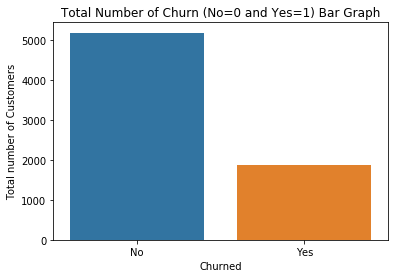

In [0]:
# Create bar graph of the Churn.
sns.countplot('Churn', data = churn_pdf)
plt.xlabel('Churned')
plt.ylabel('Total number of Customers')
plt.title('Total Number of Churn (No=0 and Yes=1) Bar Graph')
plt.show()
display()

There is a clear imbalance in the classes of the target variable.  I will take this in consideration in my evaluation and selection of the classification models later in my analysis.

In [0]:
# Print value counts of categorical variables.
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
       ]
for var in cat_cols:
    print(churn_pdf[var].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
No                     2810
Yes                

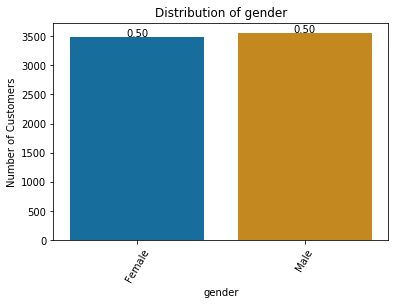

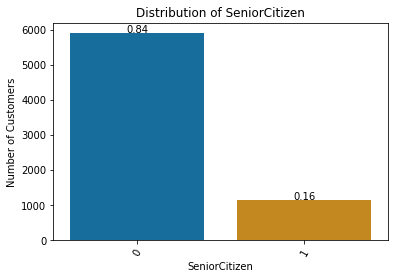

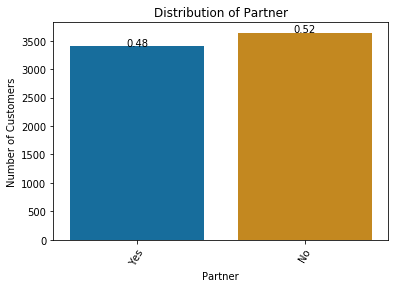

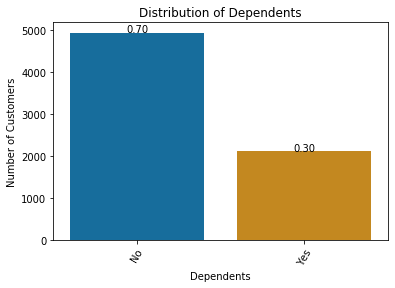

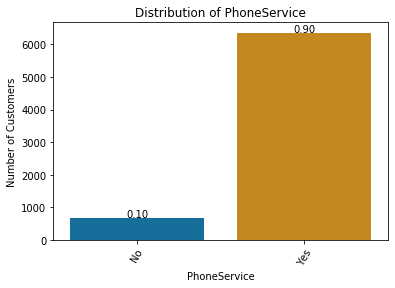

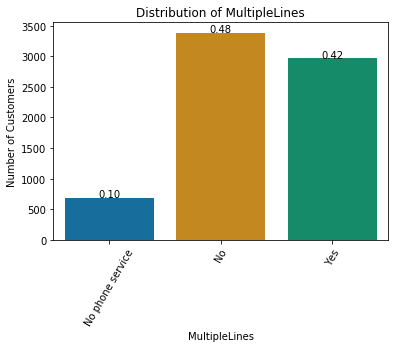

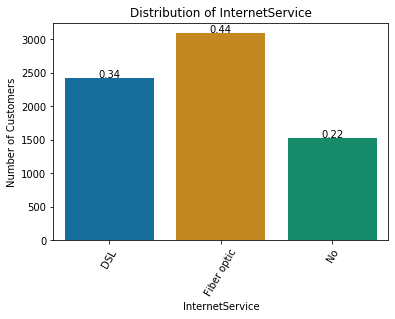

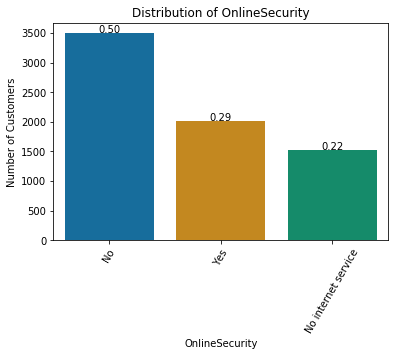

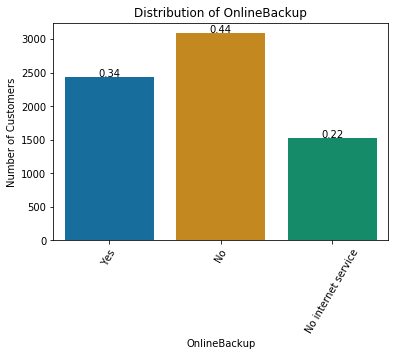

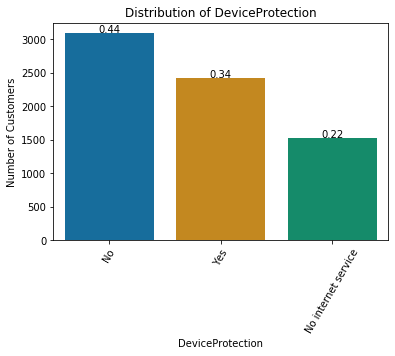

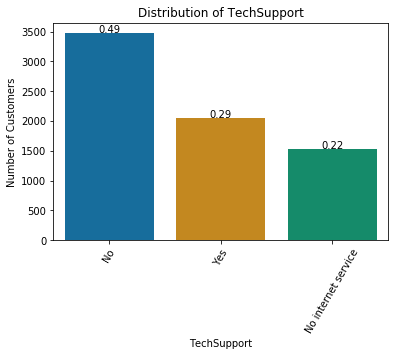

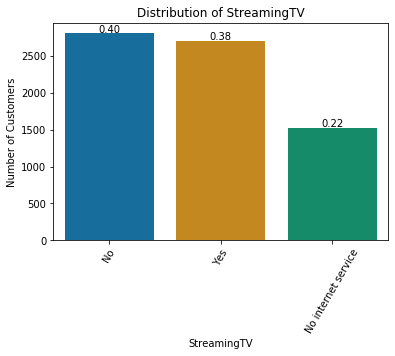

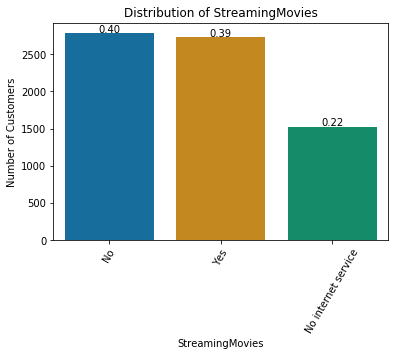

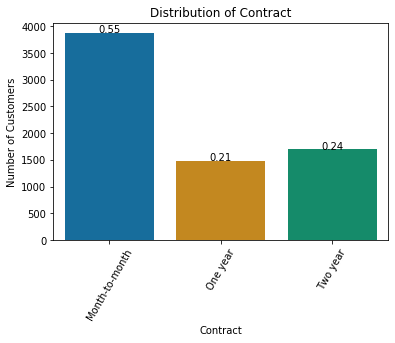

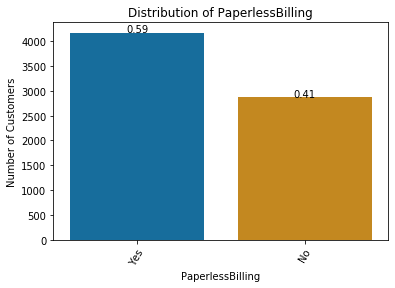

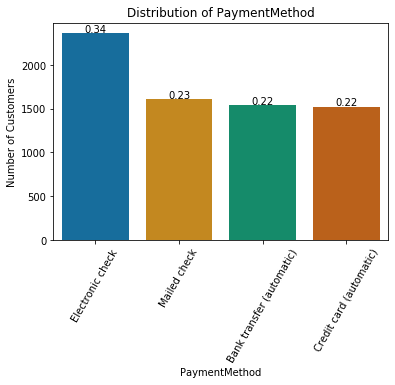

In [0]:
# Plot distributions of categorical variables.
for var in cat_cols:
    ax = sns.countplot(x = churn_pdf[var], data = churn_pdf, palette = 'colorblind')
    total = float(len(churn_pdf[var])) 
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 10,
                '{:1.2f}'.format(height/total),
                ha="center")
    plt.title('Distribution of ' + str(var))
    plt.ylabel('Number of Customers')
    plt.xticks(rotation = 60)
    plt.show()
    display()

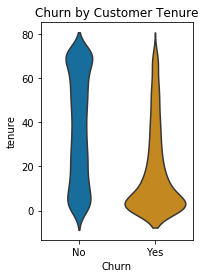

In [0]:
# Plot violinplot for churn by tenure.
plt.subplot(1,2,1)
sns.violinplot(x=churn_pdf['Churn'], y=churn_pdf['tenure'], data=churn_pdf, inner=None, palette='colorblind')
plt.title('Churn by Customer Tenure')
plt.show()
display()

The violinplot illustrates shorter time with the company the more likely they churn. The longer customers stay with the company the less likely they will churn.

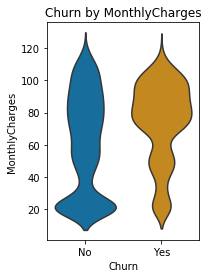

In [0]:
# Plot violinplot for churn by MontlyCharges.
plt.subplot(1,2,1)
sns.violinplot(x=churn_pdf['Churn'], y=churn_pdf['MonthlyCharges'], data=churn_pdf, inner=None, palette='colorblind')
plt.title('Churn by MonthlyCharges')
plt.show()
display()

The violinplot illustrates the higher the monthly charge on customers the more likely they will churn. The lower the monthly charge the longer customers stay with the company.

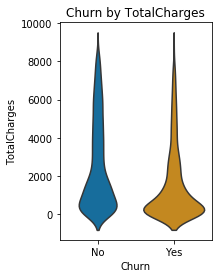

In [0]:
# Plot violinplot for churn by TotalCharges.
plt.subplot(1,2,1)
sns.violinplot(x=churn_pdf['Churn'], y=churn_pdf['TotalCharges'], data=churn_pdf, inner=None, palette='colorblind')
plt.title('Churn by TotalCharges')
plt.show()
display()

The toal charges says that in general most customers' total charges are low because they are not staying long or they enroll in less expensive contracts.

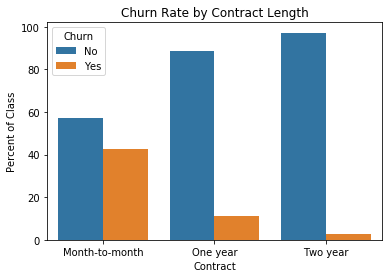

In [0]:
# Churn rate by contract length.
contract_churn = churn_pdf.groupby(['Contract', 'Churn']).agg({'customerID': 'count'})
contract = churn_pdf.groupby(['Contract']).agg({'customerID': 'count'})
contract_churn_pct = contract_churn.div(contract, level='Contract') * 100
contract_churn_pct = contract_churn_pct.reset_index()

sns.barplot(x = 'Contract' , y = 'customerID', hue = 'Churn',
            data = contract_churn_pct)
plt.title('Churn Rate by Contract Length')
plt.ylabel('Percent of Class')
plt.show()

There are more customers churning with month-to-month contract lengths than customers with two-year contracts. This means the company needs to focus on convincing more customers to sign a two-year contract over a month-to-month.

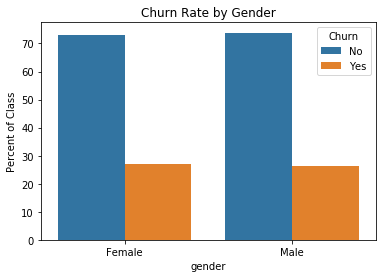

In [0]:
# Churn rate by gender.
gender_churn = churn_pdf.groupby(['gender', 'Churn']).agg({'customerID': 'count'})
gender = churn_pdf.groupby(['gender']).agg({'customerID': 'count'})
gender_churn_pct = gender_churn.div(gender, level='gender') * 100
gender_churn_pct = gender_churn_pct.reset_index()

sns.barplot(x = 'gender' , y = 'customerID', hue = 'Churn',
            data = gender_churn_pct)
plt.title('Churn Rate by Gender')
plt.ylabel('Percent of Class')
plt.show()

The churn rate between males and females are approximately the same.

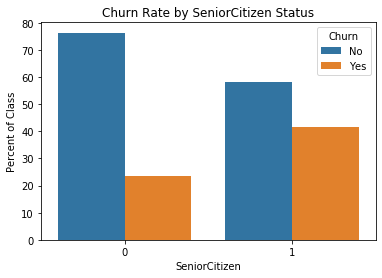

In [0]:
# Churn rate by SeniorCitizen.
internet_churn = churn_pdf.groupby(['SeniorCitizen', 'Churn']).agg({'customerID': 'count'})
internet = churn_pdf.groupby(['SeniorCitizen']).agg({'customerID': 'count'})
internet_churn_pct = internet_churn.div(internet, level='SeniorCitizen') * 100
internet_churn_pct = internet_churn_pct.reset_index()


sns.barplot(x = 'SeniorCitizen' , y = 'customerID', hue = 'Churn',
            data = internet_churn_pct)
plt.title('Churn Rate by SeniorCitizen Status')
plt.ylabel('Percent of Class')
plt.show()

The churn for senior citizens seems to be lower than not citizens.  There overall customers that are senior citizens lower than customers not senior citizens.

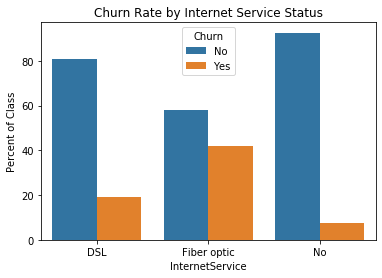

In [0]:
# Churn rate by internet service.
internet_churn = churn_pdf.groupby(['InternetService', 'Churn']).agg({'customerID': 'count'})
internet = churn_pdf.groupby(['InternetService']).agg({'customerID': 'count'})
internet_churn_pct = internet_churn.div(internet, level='InternetService') * 100
internet_churn_pct = internet_churn_pct.reset_index()


sns.barplot(x = 'InternetService' , y = 'customerID', hue = 'Churn',
            data = internet_churn_pct)
plt.title('Churn Rate by Internet Service Status')
plt.ylabel('Percent of Class')
plt.show()

Customers with fiber optic internet service churn more often than customers with DSL or no internet service. The company needs to investigate why customers are leaving with fiber optic internet service.

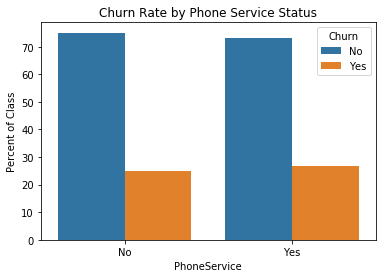

In [0]:
# Churn rate by phone service.
phone_churn = churn_pdf.groupby(['PhoneService', 'Churn']).agg({'customerID': 'count'})
phone = churn_pdf.groupby(['PhoneService']).agg({'customerID': 'count'})
phone_churn_pct = phone_churn.div(phone, level='PhoneService') * 100
phone_churn_pct = phone_churn_pct.reset_index()


sns.barplot(x = 'PhoneService' , y = 'customerID', hue = 'Churn',
            data = phone_churn_pct)
plt.title('Churn Rate by Phone Service Status')
plt.ylabel('Percent of Class')
plt.show()

Customers with or without phone service seem to not be an issue whether a customer churns or not. The churn rate is approximately the same.

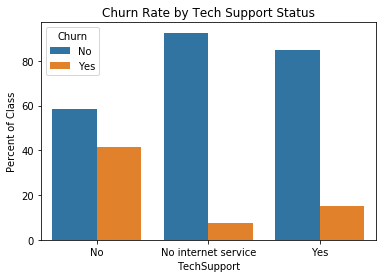

In [0]:
# Churn rate by techsupport.
tech_churn = churn_pdf.groupby(['TechSupport', 'Churn']).agg({'customerID': 'count'})
tech = churn_pdf.groupby(['TechSupport']).agg({'customerID': 'count'})
tech_churn_pct = tech_churn.div(tech, level='TechSupport') * 100
tech_churn_pct = tech_churn_pct.reset_index()


sns.barplot(x = 'TechSupport' , y = 'customerID', hue = 'Churn',
            data = tech_churn_pct)
plt.title('Churn Rate by Tech Support Status')
plt.ylabel('Percent of Class')
plt.show()

Customers who used tech support were more likely to stay than customers withou tech support. The company needs to find strategies to encourage customers to use tech support. The company also need to improve their tech support.

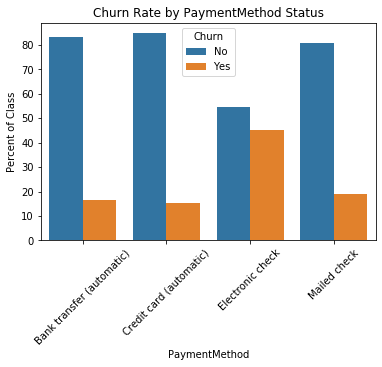

In [0]:
# Churn rate by PaymentMethod.
pay_churn = churn_pdf.groupby(['PaymentMethod', 'Churn']).agg({'customerID': 'count'})
pay = churn_pdf.groupby(['PaymentMethod']).agg({'customerID': 'count'})
pay_churn_pct = pay_churn.div(pay, level='PaymentMethod') * 100
pay_churn_pct = pay_churn_pct.reset_index()


sns.barplot(x = 'PaymentMethod' , y = 'customerID', hue = 'Churn',
            data = pay_churn_pct)
plt.title('Churn Rate by PaymentMethod Status')
plt.ylabel('Percent of Class')
plt.xticks(rotation = 45)
plt.show()

The customers with electronic check payment method churned more than the other methods.  The company can think about ways of getting their customers to pay with a credit card or bank transfer.

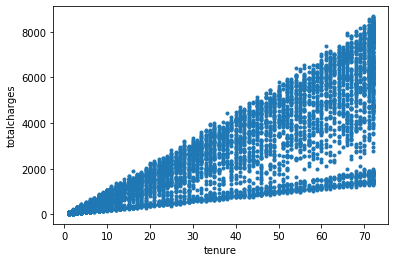

In [0]:
# Scatterplot for tenure versus TotalCharges.
import matplotlib.pyplot as plt
plt.clf()
plt.plot(churn_pdf['tenure'], churn_pdf['TotalCharges'], '.')
plt.xlabel('tenure')
plt.ylabel('totalcharges')
display()

The scatterplot indicates the longer a customer stays the more revenue the company receives.  The tenure trend indicates customers leave at the beginning of service.  This trend follows the length of contract bar chart.  The company can retain customers by giving them incentives to sign a longer term contract.  

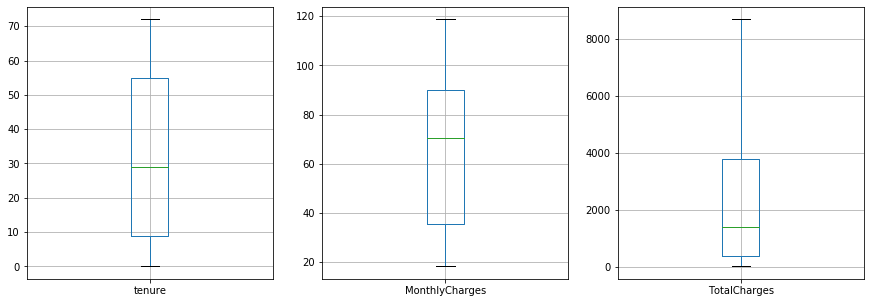

In [0]:
# Detecting outliers through plotting box plots
plt.figure(figsize=(15, 5))
for i, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges'], start=1):
    plt.subplot(1, 3, i)
    churn_pdf.boxplot(col,whis=1.5)
plt.show()
display()

In [0]:
# Calculate number of outliers and its percentage with Tukey's method.
for i, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges'], start=1):
    q75, q25 = np.percentile(churn_pdf[col], [75, 25])
    iqr = q75 - q25
    
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(col,
                                                                            len((np.where((churn_pdf[col] > max_val) | 
                                                                                           (churn_pdf[col] < min_val))[0])),
                                                                             len((np.where((churn_pdf[col] > max_val) | 
                                                                                           (churn_pdf[col] < min_val))[0]))*100/7043))

Number of outliers and percentage of it in tenure : 0 and 0.0
Number of outliers and percentage of it in MonthlyCharges : 0 and 0.0
Number of outliers and percentage of it in TotalCharges : 0 and 0.0


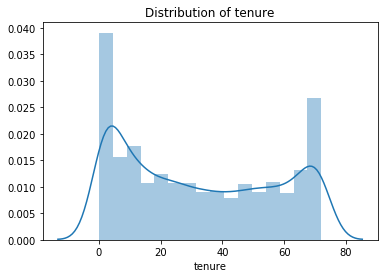

In [0]:
# Check the distributions of the tenure.
sns.distplot(churn_pdf['tenure'])
plt.title('Distribution of tenure')
display()

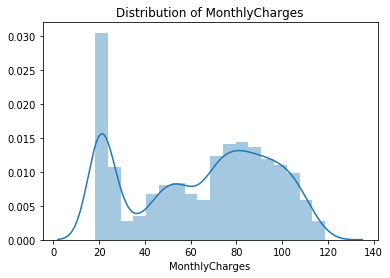

In [0]:
# Check the distributions of the MonthlyCharges.
sns.distplot(churn_pdf['MonthlyCharges'])
plt.title('Distribution of MonthlyCharges')
display()

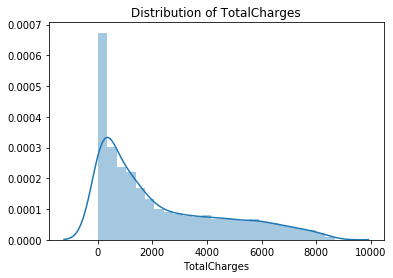

In [0]:
# Check the distributions of the TotalCharges.
sns.distplot(churn_pdf['TotalCharges'].fillna(0))
plt.title('Distribution of TotalCharges')
display()

The distributions show there exists skewness in the numeric variables. 

In [0]:
# Drop customerID and gender.  These columns are irrelevant to the analysis.
cols_to_drop = ['customerID', 'Gender']
df = df.drop(*cols_to_drop)

## Creating Pipeline for ML Models

In [0]:
# Preparing the data for encoding.
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

catColumns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
              'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
              'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [0]:
# Encoding the categorical variables with One Hot Encoding.
stages = []

for catCol in catColumns:
  stringIndexer = StringIndexer(inputCol=catCol, outputCol=catCol + 'Index')
  encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[catCol + 'catVec'])
  stages += [stringIndexer, encoder]

In [0]:
# Imputing TotalCharges to address the missing values.
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=['TotalCharges'], outputCols=['Out_TotalCharges'])
stages += [imputer]

In [0]:
# Convert Churn to 1's and 0's.
label_Idx = StringIndexer(inputCol='Churn', outputCol='label')
stages += [label_Idx]

In [0]:
# Placing tenure values into 3 bins based on quartiles.
from pyspark.ml.feature import QuantileDiscretizer
tenure_bin = QuantileDiscretizer(numBuckets=3, inputCol='tenure', outputCol='tenure_bin')
stages += [tenure_bin]

In [0]:
# Vertorizing the values in the pipeline.
numericCols = ['tenure_bin', 'MonthlyCharges', 'Out_TotalCharges']
assembleInputs = [c + 'catVec' for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols=assembleInputs, outputCol='features')
stages += [assembler]

In [0]:
# Split the data into training and validation (test).
churn_df = df
(train_data, test_data) = churn_df.randomSplit([0.7, 0.3], 24)

print('Observations for training: ' + str(train_data.count()))
print('Obervations for evaluation: ' + str(test_data.count()))

Observations for training: 4916
Obervations for evaluation: 2127


In [0]:
# Create pipeline.
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(train_data)

In [0]:
# Split based on the vectorized data.
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

## Logistic Regression

In [0]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model.
lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=10)

# Train model with Training Data.
lrModel = lr.fit(trainprepDF)

# Predict with lr on train and test.
predict_train = lrModel.transform(trainprepDF)
predict_test = lrModel.transform(testprepDF)
predict_test.select('Label', 'Prediction').show(5)

+-----+----------+
|Label|Prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')
predict_test.select('Label','rawPrediction','prediction','probability').show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+-----+--------------------+----------+--------------------+
|Label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  1.0|[0.11210950749062...|       0.0|[0.52799805844991...|
|  0.0|[0.10999726412407...|       0.0|[0.52747162244040...|
|  0.0|[-0.0570277354445...|       1.0|[0.48574692870497...|
|  0.0|[0.29850327646466...|       0.0|[0.57407658959989...|
|  1.0|[0.29474817714635...|       0.0|[0.57315816588715...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.8422454597158734
The area under ROC for test set is 0.8425991351447739


In [0]:
predictionsLR = lrModel.transform(testprepDF)
results = predictionsLR.select(['prediction', 'label']) 

In [0]:
count = predictionsLR.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))

Correct: 1699
Wrong: 428
tp: 307
fp: 155
fn: 273
tn: 1392
Accuracy: 0.7987776210625294
Precision: 0.6645021645021645
Recall: 0.5293103448275862


## Hyperparameter Tuning Logistic Regression

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.aggregationDepth,[2,5,10])\
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.maxIter,[10, 20, 30])\
    .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
    .build()

In [0]:
# Crossvalidation
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.
cvModelLR = cv.fit(trainprepDF)

In [0]:
# Evaluating the cvModelLR.
predict_train=cvModelLR.transform(trainprepDF)
predict_test=cvModelLR.transform(testprepDF)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set after CV  is 0.8432931147588724
The area under ROC for test set after CV  is 0.8426058221697236


In [0]:
cvpredictionsLR = cvModelLR.transform(testprepDF)
results = cvpredictionsLR.select(['prediction', 'label']) 

In [0]:

count = cvpredictionsLR.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))

Correct: 1697
Wrong: 430
tp: 303
fp: 153
fn: 277
tn: 1394
Accuracy: 0.7978373295721674
Precision: 0.6644736842105263
Recall: 0.5224137931034483


## Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label',
                            featuresCol='features').setImpurity('gini').setMaxDepth(6).setNumTrees(50).setFeatureSubsetStrategy('auto').setSeed(101)

# Train model with Training Data.
rfModel = rf.fit(trainprepDF)

# Predict with rf on train and test.
predict_train = rfModel.transform(trainprepDF)
predict_test = rfModel.transform(testprepDF)
predict_test.select('Label', 'Prediction').show(5)

+-----+----------+
|Label|Prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorRF = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')
predict_test.select('Label','rawPrediction','prediction','probability').show(5)
print("The area under ROC for train set is {}".format(evaluatorRF.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluatorRF.evaluate(predict_test)))

+-----+--------------------+----------+--------------------+
|Label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  1.0|[25.3649145903208...|       0.0|[0.50729829180641...|
|  0.0|[25.3649145903208...|       0.0|[0.50729829180641...|
|  0.0|[22.5709334511444...|       1.0|[0.45141866902288...|
|  0.0|[26.3489808191521...|       0.0|[0.52697961638304...|
|  1.0|[25.9717924902396...|       0.0|[0.51943584980479...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.8591094333230007
The area under ROC for test set is 0.8423171655930276


In [0]:
predictionsRF = rfModel.transform(testprepDF)
results = predictionsRF.select(['prediction', 'label']) 

In [0]:
count = predictionsRF.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))

Correct: 1691
Wrong: 436
tp: 261
fp: 117
fn: 319
tn: 1430
Accuracy: 0.7950164551010813
Precision: 0.6904761904761905
Recall: 0.45


## Hyparameter Tuning Random Forest Classifier

In [0]:
# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [8, 10, 12])
    .addGrid(rf.minInstancesPerNode, [1, 3, 5, 10])
    .addGrid(rf.numTrees, [50, 100])
    .build()
)


In [0]:
# Crossvalidation
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluatorRF, numFolds=5)
# Run cross validations.
cvModelRF = cv.fit(trainprepDF)

In [0]:
cvpredictionsRF = cvModelRF.transform(testprepDF)
results = cvpredictionsRF.select(['prediction', 'label']) 

In [0]:
count = cvpredictionsRF.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))

Correct: 1692
Wrong: 435
tp: 281
fp: 136
fn: 299
tn: 1411
Accuracy: 0.7954866008462623
Precision: 0.6738609112709832
Recall: 0.4844827586206897


## Gradient-Boosted Trees Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', maxIter=10)

# Train model with Training Data.
gbtModel = gbt.fit(trainprepDF)

# Predict with gbt on train and test.
predict_train = gbtModel.transform(trainprepDF)
predict_test = gbtModel.transform(testprepDF)
predict_test.select('Label', 'Prediction').show(5)

+-----+----------+
|Label|Prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorGBT = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')
predict_test.select('Label','rawPrediction','prediction','probability').show(5)
print("The area under ROC for train set is {}".format(evaluatorGBT.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluatorGBT.evaluate(predict_test)))

+-----+--------------------+----------+--------------------+
|Label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  1.0|[0.11029549594593...|       0.0|[0.55492520492274...|
|  0.0|[0.11029549594593...|       0.0|[0.55492520492274...|
|  0.0|[-0.2373056662679...|       1.0|[0.38352538539035...|
|  0.0|[0.11029549594593...|       0.0|[0.55492520492274...|
|  1.0|[0.11029549594593...|       0.0|[0.55492520492274...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.8760584299761954
The area under ROC for test set is 0.8425952343802251


In [0]:
predictionsGBT = gbtModel.transform(testprepDF)
results = predictionsGBT.select(['prediction', 'label']) 

In [0]:
count = predictionsGBT.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))

Correct: 1682
Wrong: 445
tp: 301
fp: 166
fn: 279
tn: 1381
Accuracy: 0.7907851433944523
Precision: 0.6445396145610278
Recall: 0.5189655172413793


# Hyperparameter Tuning Gradient Boost Tree Classifier

In [0]:
# Use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [8, 10])
    .addGrid(gbt.minInstancesPerNode, [5, 20, 50])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

In [0]:
# Crossvalidation
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluatorGBT, numFolds=5)
# Run cross validations.
cvModelGBT = cv.fit(trainprepDF)

In [0]:
cvpredictionsGBT = cvModelGBT.transform(testprepDF)
results = cvpredictionsGBT.select(['prediction', 'label']) 

In [0]:
count = cvpredictionsGBT.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))

Correct: 1685
Wrong: 442
tp: 293
fp: 155
fn: 287
tn: 1392
Accuracy: 0.7921955806299953
Precision: 0.6540178571428571
Recall: 0.5051724137931034


# Conclusions
I will use logistic regression because the recall, precision, and arear under the ROC curve are the highest after hyperparameter tuning and cross validation.  Logistic regression will predict churn the best out of the three models I evaluated.  The performance of the models suffered from the imbalance of the target classes.  There is overfitting happening in all three models.  The indication is in the wide range of evaluation metrics.  One way to address this is through regularization such as Lasso or Ridge regression.  

# Future Research
Some ways I could improve the models performance are engineer the features by normalizing them and balance the target classes through undersampling or oversampling.  I could consult with domain experts on how to create new features.  I want to investigate other models offered by PySpark MLLib with better performance. 

# Customer Segmentation
I want to segment the data into clusters for the marketing team to use to target certain customers from leaving.  It is cheaper for the company to retain customers than acquiring new ones.

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model
kmeans = KMeans(featuresCol="features", k=4, initSteps=2, tol=0.0001, maxIter=20)
model = kmeans.fit(testprepDF)

In [0]:
# Make predictions
clusters = model.transform(trainprepDF)

In [0]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(clusters)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7535039579954576


In [0]:
# Evaluate clustering.
cost = model.computeCost(trainprepDF)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 1492614673.9889154


In [0]:
# Create a Pandas DataFrame for data visualization.
cluster = clusters.toPandas()

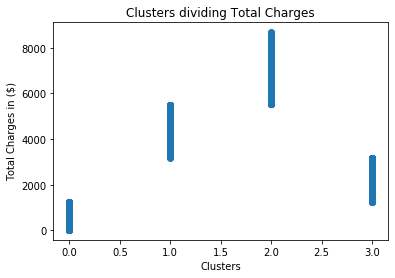

In [0]:
# Plot clusters against TotalCharges.
plt.scatter(cluster['prediction'], cluster['TotalCharges'])
plt.ylabel('Total Charges in ($)')
plt.xlabel('Clusters')
plt.title('Clusters dividing Total Charges')
plt.show()

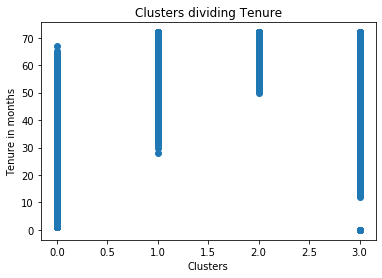

In [0]:
# Plot clusters against TotalCharges.
plt.scatter(cluster['prediction'], cluster['tenure'])
plt.ylabel('Tenure in months')
plt.xlabel('Clusters')
plt.title('Clusters dividing Tenure')
plt.show()

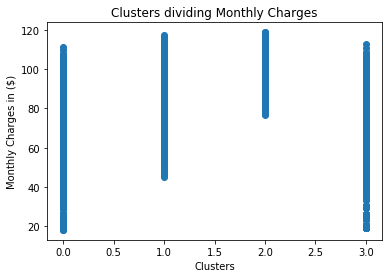

In [0]:
# Plot clusters against TotalCharges.
plt.scatter('prediction', 'MonthlyCharges', data=cluster)
plt.ylabel('Monthly Charges in ($)')
plt.xlabel('Clusters')
plt.title('Clusters dividing Monthly Charges')
plt.show()

# Conclusions on Customer Segmentations
Based on the clusters 0, 1, 2, 3, I can divide up the customers through tenure, monthly charges, and total charges.  When the silhouette score is 0.75, I can rely on the clusters information. 

In cluster 0, the customers have lower total charges range (approximately 0 - 1,700 dollars), wide tenure range (approximately 0 - 69 months), and high monthly charges range (approximately 0 - 110 dollars).  This means customers in cluster 0 tend to leave and not stay with the company for long.  These customers have lower value to the company.  These are the company's lowest value customers and most unpredictable customers.  These customers are bargain shoppers.  The company should not put in as much effort into keep these customers.  The customers leave when they feel they are not getting a good deal.  

In cluster 1, the customers have high total charges range (approximately 3,000 - 5,500 dollars), more narrow tenure range (approximately 30 - 70 months), and high monthly charges range (approximately 45 - 120 dollars).  This means customers in cluster 1 tend to stay longer and have higher value to the company.  These customers are our second highest value customers.  The company can find marketing strategies that offer incentives to 2-year contract with better services.

In cluster 2, the customers have higher total charges range (approximately 5,500 - 9,500 dollars), most narrow tenure range (approximately 50 - 70 months), and high monthly charges range (approximately 80 - 125 dollars).  This means customers in cluster 2 tend to stay longer and order premium services.  The customers in this cluster bring high value to the company.  The company's marketing strategy can include discounts on 2-year contracts with premium services.  These customers are highest value customers.  

In cluster 3, the customers have lower total charges range (approximately 1,700 - 3,000 dollars), wide tenure range (approximately 10 - 70 months), and similar monthly charges range (approximately 10 - 70 dollars) to cluster 0.  This means the customers in cluster 3 tend to leave sooner because they are looking for a bargain.  They do stay slightly longer than cluster 0.  These customers bring slightly higher value to the company than cluster 0.  The company's marketing stategy can be to offer incentives for one-year or two-year contracts.
